In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cpu")
print("Using device:", device)


Using device: cpu


In [2]:
transform = transforms.ToTensor()

train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set   = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_size = 50000
val_size   = len(train_full) - train_size

train_set, val_set = random_split(train_full, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=50, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=50, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=50, shuffle=False)

len(train_set), len(val_set), len(test_set)


(50000, 10000, 10000)

In [3]:
class CNNPoolingModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(6, 10, kernel_size=3, stride=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)

        # 28x28 → conv1 3x3 → 26x26 → pool → 8x8
        # 8x8 → conv2 3x3 → 6x6 → pool → 2x2
        self.fc = nn.Linear(10 * 2 * 2, 10)

        self.softmax = nn.LogSoftmax(dim=1)

        # Xavier init
        for layer in [self.conv1, self.conv2, self.fc]:
            nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # flatten: (batch, 40)
        x = self.fc(x)
        return self.softmax(x)

model = CNNPoolingModel().to(device)
model


CNNPoolingModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=40, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [4]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (preds.argmax(1) == y).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            total_loss += loss.item() * x.size(0)
            correct += (preds.argmax(1) == y).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


In [5]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

EPOCHS = 100
patience = 10

best_val_loss = float('inf')
best_model_state = None
no_improve_epochs = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    scheduler.step()

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1:3d} | "
        f"Train Loss: {tr_loss:.4f}, Val Loss: {val_loss:.4f}, "
        f"Train Acc: {tr_acc:.4f}, Val Acc: {val_acc:.4f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping triggered!")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)


Epoch   1 | Train Loss: 0.3493, Val Loss: 0.1925, Train Acc: 0.8861, Val Acc: 0.9419
Epoch   2 | Train Loss: 0.1628, Val Loss: 0.1413, Train Acc: 0.9494, Val Acc: 0.9556
Epoch   3 | Train Loss: 0.1511, Val Loss: 0.1421, Train Acc: 0.9531, Val Acc: 0.9549
Epoch   4 | Train Loss: 0.1518, Val Loss: 0.1404, Train Acc: 0.9534, Val Acc: 0.9557
Epoch   5 | Train Loss: 0.1367, Val Loss: 0.1396, Train Acc: 0.9582, Val Acc: 0.9583
Epoch   6 | Train Loss: 0.1373, Val Loss: 0.1523, Train Acc: 0.9573, Val Acc: 0.9530
Epoch   7 | Train Loss: 0.1259, Val Loss: 0.1773, Train Acc: 0.9608, Val Acc: 0.9533
Epoch   8 | Train Loss: 0.1296, Val Loss: 0.1445, Train Acc: 0.9598, Val Acc: 0.9577
Epoch   9 | Train Loss: 0.1213, Val Loss: 0.1468, Train Acc: 0.9629, Val Acc: 0.9596
Epoch  10 | Train Loss: 0.1267, Val Loss: 0.1336, Train Acc: 0.9609, Val Acc: 0.9629
Epoch  11 | Train Loss: 0.1152, Val Loss: 0.1221, Train Acc: 0.9645, Val Acc: 0.9652
Epoch  12 | Train Loss: 0.1125, Val Loss: 0.1132, Train Acc: 0.96

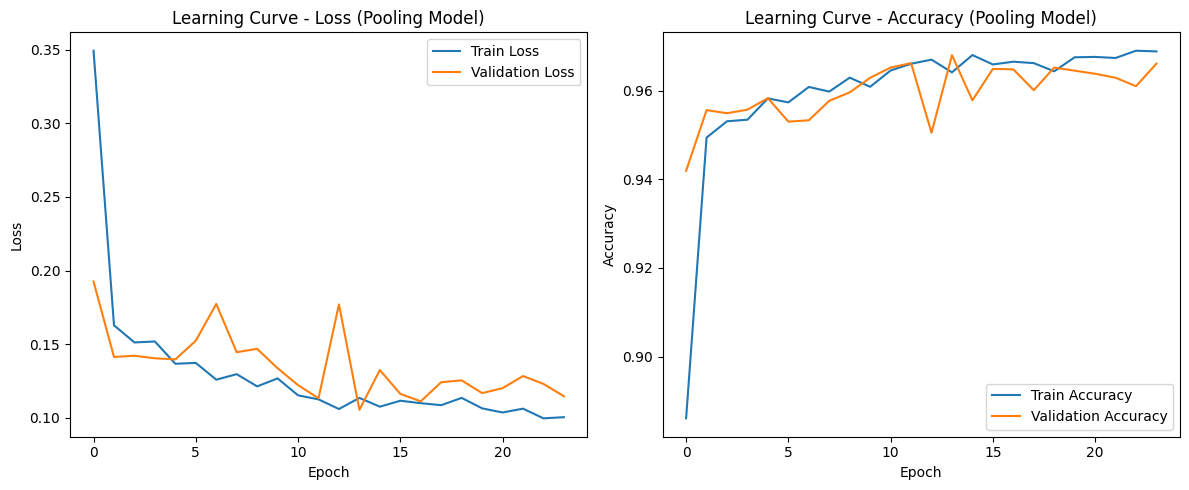

In [6]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve - Loss (Pooling Model)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Accuracy (Pooling Model)")
plt.legend()

plt.tight_layout()
plt.show()


### Comparison of Pooling Model vs Baseline Model

The pooling model shows a noticeably different learning behavior compared to the baseline CNN without pooling. First, the training and validation losses decrease smoothly and remain very close to each other throughout training. This indicates that the pooling model is less prone to overfitting than the baseline model. In the baseline system, the validation loss began increasing after several epochs (mild overfitting), whereas in the pooling version the validation loss stays more stable, even when the training loss continues to decline.

Pooling also enforces a form of spatial invariance by reducing the spatial resolution of the feature maps. This simplifies the model and reduces the number of parameters in the fully connected layer. As a result, the model converges slightly more slowly than the baseline early in training, but becomes more stable and consistent after the first few epochs. Validation accuracy remains very close to training accuracy, showing that the model generalizes well.

Overall, the pooling model does **not** significantly outperform the baseline in accuracy, but it shows **less overfitting** and produces smoother, more stable learning curves. The model provides a good fit with improved generalization behavior compared to the baseline.


Test Accuracy: 96.99%


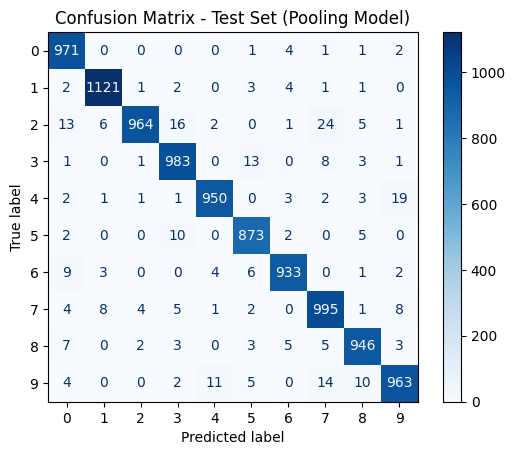

In [7]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = (all_preds == all_labels).mean()
print(f"Test Accuracy: {test_acc * 100:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test Set (Pooling Model)")
plt.show()


### Confusion Matrix Analysis – Pooling Model vs Baseline

The pooling model achieves a test accuracy of approximately **96.99%**, which is slightly lower than the baseline model (around ~98%). This drop in accuracy is expected because max pooling reduces spatial resolution early in the network, causing some fine-grained digit features to be lost.

From the confusion matrix, most digits are classified correctly, but the following patterns stand out:

- **Digit 5 is misclassified as 3 or 8** in several cases. These digits share similar curved structures, and pooling may remove important local edge details needed to distinguish them.
- **Digit 9 is sometimes predicted as 4 or 7**, which also happened in the baseline model, but the pooling model shows slightly more confusion here due to reduced spatial detail.
- **Digits 0, 1, and 7** remain very easy for the model, with almost no misclassifications.
- **Digit 8 shows occasional confusion with 0, 3, and 9**, likely because pooling tends to smooth out small variations inside the loops of 8.

Compared to the baseline, the pooling model produces a confusion matrix that is overall similar but slightly noisier. This matches the learning curve behavior: pooling improves generalization stability but occasionally causes the model to lose important structural details, leading to a small performance drop. 


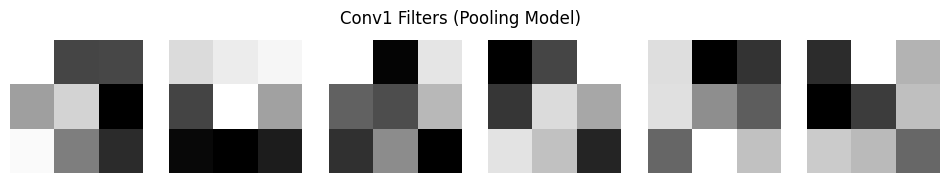

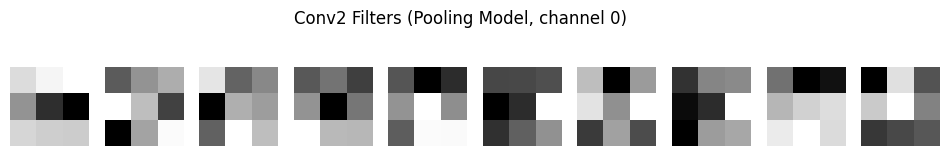

In [8]:
def show_kernels(weights, title):
    w = weights.detach().cpu().numpy()
    num_kernels = w.shape[0]

    plt.figure(figsize=(12, 2))
    for i in range(num_kernels):
        plt.subplot(1, num_kernels, i+1)
        plt.imshow(w[i, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_kernels(model.conv1.weight, "Conv1 Filters (Pooling Model)")
show_kernels(model.conv2.weight[:, :1], "Conv2 Filters (Pooling Model, channel 0)")


### Filter Visualization – Pooling Model

The Conv1 filters in the pooling model still resemble edge and stroke detectors, but they appear slightly smoother and less detailed compared to the baseline CNN. This is expected because max pooling reduces spatial resolution early in the network, encouraging the model to learn more general, low-frequency patterns rather than fine-grained edges.

The Conv2 filters show more abstract and blob-like structures. Since the feature maps at this stage have already been downsampled twice, the network focuses on coarse shapes and high-level digit structures instead of small localized patterns. Compared to the baseline model, these filters look broader and less sharp, reflecting the translation-invariant nature introduced by pooling.

Overall, the pooling model’s filters suggest that the network relies on simpler, more global visual cues. This helps generalization but may reduce sensitivity to subtle digit features, which explains the slight drop in accuracy compared to the baseline system.
